In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import datetime
import json
from pprint import pprint
from IPython.core import display as ICD  # to print multiple nice pandas tables
from collections import defaultdict
import logging
import numpy as np
import io
import gensim
from tqdm import tqdm_notebook, tnrange
import tqdm
import seaborn as sns
sns.set()

In [3]:
import datasets
import classify

In [107]:
from sklearn.linear_model import LogisticRegression
from gensim.models import TfidfModel
class SimpleModel(object):
    def __init__(self, cls=None, use_tfidf=False, w=None, use_svd=True):
        self.cls = cls
        if self.cls is None:
            self.cls = LogisticRegression()
        self.use_tfidf = use_tfidf
        self.w = w
        self.use_svd = use_svd
        

    def fit(self, X, Y):
        self.dictionary = gensim.corpora.Dictionary(X)
        self.num_terms = len(self.dictionary.dfs)
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            self.tfidf_model = TfidfModel(bow)
            bow = self.tfidf_model[bow]
        if self.w is None:
            self.w = np.ones(self.num_terms)
        if self.use_svd:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            bow = gensim.matutils.Sparse2Corpus(bow.multiply(self.w.reshape(-1,1)))
            self.lsi = gensim.models.LsiModel(bow, id2word=self.dictionary)
            self.corpus = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        else:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            self.corpus = bow.multiply(self.w.reshape(-1,1)).T
            
        self.cls.fit(self.corpus, Y)
    
    def dw(self, X, Y):
        _ = self.predict(X)
        self.d_embedding = self.cls.dx(self.embedding, Y)
        u = self.lsi.projection.u
        res = self.d_embedding.dot(u.T)
        dw = model.bow.multiply(res.T).sum(axis=1).T.A1
        return dw
        
    
    def predict(self, X):
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            bow = self.tfidf_model[bow]
        if self.use_svd:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            self.bow = bow
            bow = bow.multiply(self.w.reshape(-1,1))
            bow = gensim.matutils.Sparse2Corpus(bow)
            self.embedding = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        else:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            self.bow = bow
            self.embedding = bow.multiply(self.w.reshape(-1,1)).T            
        Yhat = self.cls.predict(self.embedding)
        return Yhat
    
    def score(self, X, Y):
        Yhat = self.predict(X)
        return 1-((Yhat-Y)**2).mean()
    
    def update(self, X, Y):
        pass

In [108]:
def noice_like(like, spread=0.01):
    rnd = np.random.random(size=like.shape)
    rnd *= spread
    rnd -= spread/2
    return rnd

# Check how balanced are the datasets

In [6]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]

In [7]:
for dataset in all_datasets:
    print(dataset.name(), dataset.baseline())

CRDataset 0.6376158940397351
MRDataset 0.5
SUBJDataset 0.5
MPQADataset 0.6877239298510277


In [137]:
from collections import defaultdict
results = defaultdict(dict)

In [138]:
def test_simple_model(model, dataset, iters=1, tag=None):
    precisions = []
    for it in tnrange(iters):
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_p = model.score(dataset.train_samples(), dataset.train_labels())
        test_p = model.score(dataset.test_samples(), dataset.test_labels())
        precisions.append((train_p, test_p))
    train, test = list(zip(*precisions))
    print(dataset.name())
    if tag is not None:
        results[dataset.name()][('simple', tag)] = (np.mean(train), np.mean(test))
    print("Train precision", np.min(train), np.mean(train), np.max(train))
    print("Test precision", np.min(test), np.mean(test), np.max(test))

# Test bow benchmark

In [115]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_svd=False)
    test_simple_model(model, dataset, 5, 'bow')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.9696791286429203 0.9696791286429203 0.9696791286429203
Test precision 0.7936507936507937 0.7936507936507937 0.7936507936507937


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.9770713913496613 0.9770713913496613 0.9770713913496613
Test precision 0.7769447047797563 0.7769447047797563 0.7769447047797563


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.9937777777777778 0.9937777777777776 0.9937777777777778
Test precision 0.919 0.9190000000000002 0.919


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.9091671031953903 0.9091671031953903 0.9091671031953903
Test precision 0.8322337417530632 0.8322337417530632 0.8322337417530632


In [116]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_svd=False, use_tfidf=True)
    test_simple_model(model, dataset, 5, 'bow_tfidf')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.8943185163379452 0.8943185163379452 0.8943185163379452
Test precision 0.8068783068783069 0.8068783068783068 0.8068783068783069


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.9081813444502345 0.9081813444502345 0.9081813444502345
Test precision 0.7750702905342081 0.7750702905342081 0.7750702905342081


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.9606666666666667 0.9606666666666668 0.9606666666666667
Test precision 0.916 0.916 0.916


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.876270298585647 0.876270298585647 0.876270298585647
Test precision 0.822808671065033 0.8228086710650329 0.822808671065033


# Testing lsa + sklearn logistic regression 

In [117]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model(model, dataset, 5, 'default')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.7821607300559317 0.7839269944068296 0.787165145716809
Test precision 0.7433862433862434 0.7507936507936508 0.7592592592592593


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.6857738405419489 0.6896925482021887 0.6926524231370506
Test precision 0.6607310215557638 0.6674789128397375 0.6729147141518276


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.8831111111111111 0.8858666666666668 0.8883333333333333
Test precision 0.869 0.8741999999999999 0.88


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.756731272917758 0.7603981141959142 0.7632268203247774
Test precision 0.7370405278039585 0.7408105560791706 0.7436380772855796


# Testing lsa + custom logistic regression 

In [118]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.CustomClassifier())
    test_simple_model(model, dataset, 5, 'custom_regression')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.6376214306741242 0.6376214306741242 0.6376214306741242
Test precision 0.6375661375661376 0.6375661375661376 0.6375661375661376


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.6983845752996352 0.7029494528400207 0.7072433559145388
Test precision 0.6551077788191191 0.6629803186504217 0.6701030927835052


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.882 0.8883333333333333 0.894
Test precision 0.855 0.8613999999999999 0.869


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.6876898899947617 0.6876898899947617 0.6876898899947617
Test precision 0.6880301602262017 0.6880301602262017 0.6880301602262017


We see real decrease against sklearn classsifier in some tasks. In CR and MPQAD we hit the baseline, which is bad.

# Add tfidf

In [121]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model(model, dataset, 5, 'tfidf')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.7886370326758905 0.7931704445098615 0.7965852222549308
Test precision 0.7619047619047619 0.7714285714285715 0.7804232804232805


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.7151641479937467 0.7188118811881188 0.7243355914538823
Test precision 0.711340206185567 0.7162136832239925 0.725398313027179


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.8961111111111111 0.896488888888889 0.8966666666666667
Test precision 0.887 0.8892 0.892


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.7819800942902043 0.7862336301728654 0.7888947092718701
Test precision 0.7502356267672008 0.7557021677662583 0.7577756833176249


# Try improwing $w$ with gradient

In [140]:
raw_results = defaultdict(dict)

In [44]:
def gradient_w(model, dataset, alpha=0.01, epochs=150):
    train_scores = []
    test_scores = []
    model.fit(dataset.train_samples(), dataset.train_labels())
    if epochs is None:
        t = tnrange(100000)
    else:
        t = tnrange(epochs)
    for e in t:
        w = np.copy(model.w)
        w -= alpha * model.dw(dataset.train_samples(), dataset.train_labels())
        model.w = np.copy(w)
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_score = model.score(dataset.train_samples(), dataset.train_labels())
        test_score = model.score(dataset.test_samples(), dataset.test_labels())
        train_scores.append(train_score)
        test_scores.append(test_score)
        t.set_postfix(train_score=train_score, test_score=test_score)
        if epochs is None and e > 20:
            end_mean = np.mean(train_scores[-10:])
            previos_mean = np.mean(train_scores[-20:-10])
            t.set_postfix(train_score=train_score, test_score=test_score, previos=previos_mean, end=end_mean)
            if end_mean < previos_mean:
                break
    plt.plot(train_scores,)
    plt.plot(test_scores)
    plt.legend(['train', 'test'])
    return train_scores, test_scores

In [139]:
def test_simple_model_with_gradient(model, dataset, gradient_iters=150, alpha=0.01, tag=None):
    train_ps, test_ps = gradient_w(model, dataset, alpha, gradient_iters)
    train_p = model.score(dataset.train_samples(), dataset.train_labels())
    test_p = model.score(dataset.test_samples(), dataset.test_labels())
    if tag is not None:
        results[dataset.name()][('gradientw', tag, alpha)] = (train_p, test_p)
        raw_results[dataset.name()][('gradientw', tag, alpha)] = (train_ps, test_ps)
    plt.show()
    print(dataset.name())
    print("Train precision", train_p)
    print("Test precision", test_p)

# Precision of model when we do not update $w$

it is basically 150 fits of LSA + logistic regression

In [51]:
models = {}

HBox(children=(IntProgress(value=0), HTML(value='')))

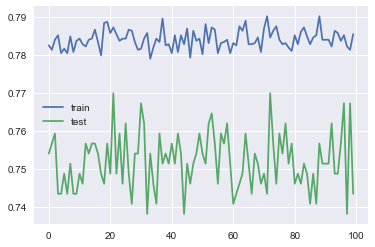

CRDataset
Train precision 0.7853988813659111
Test precision 0.7433862433862434


HBox(children=(IntProgress(value=0), HTML(value='')))

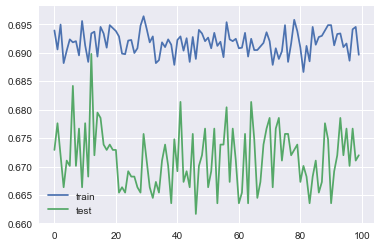

MRDataset
Train precision 0.6896300156331423
Test precision 0.6719775070290535


HBox(children=(IntProgress(value=0), HTML(value='')))

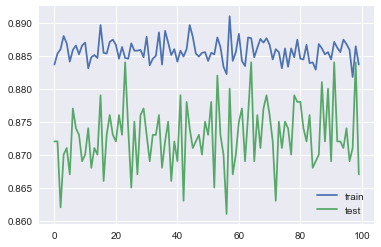

SUBJDataset
Train precision 0.8836666666666667
Test precision 0.867


HBox(children=(IntProgress(value=0), HTML(value='')))

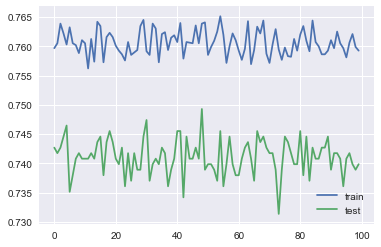

MPQADataset
Train precision 0.7592456783656365
Test precision 0.7398680490103675


In [33]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model_with_gradient(model, dataset, alpha=0, tag='default', gradient_iters=100)
    models[(dataset.name(), 'no_w')] = model


# Precision, when we do update w

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

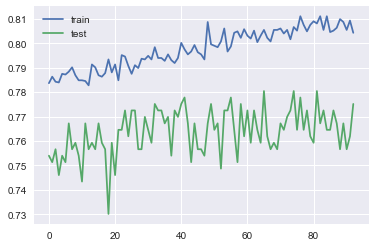

CRDataset
Train precision 0.8042390344421548
Test precision 0.7751322751322751


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

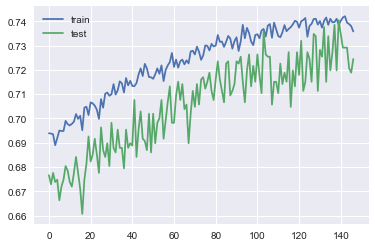

MRDataset
Train precision 0.7357998957790516
Test precision 0.7244611059044048


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

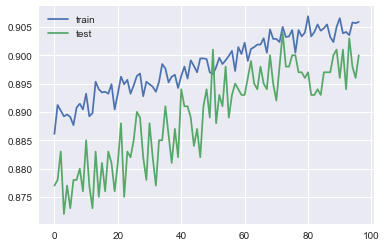

SUBJDataset
Train precision 0.9058888888888889
Test precision 0.9


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

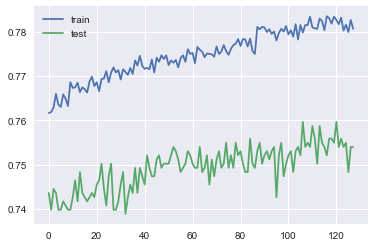

MPQADataset
Train precision 0.7806181246726035
Test precision 0.7540056550424128


In [58]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model_with_gradient(model, dataset, gradient_iters=None, alpha=0.01, tag='default')
    models[(dataset.name(), 'update_w')] = model

update with smaller $\alpha$

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

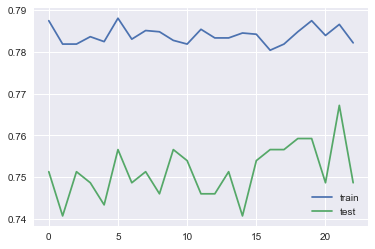

CRDataset
Train precision 0.7821607300559317
Test precision 0.7486772486772486


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

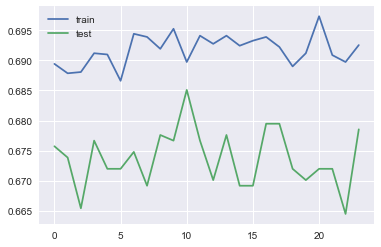

MRDataset
Train precision 0.69254820218864
Test precision 0.6785379568884724


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

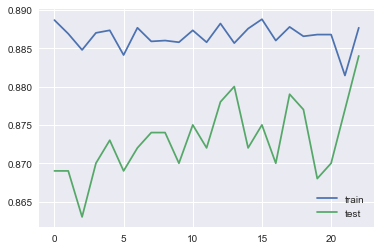

SUBJDataset
Train precision 0.8876666666666667
Test precision 0.884


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

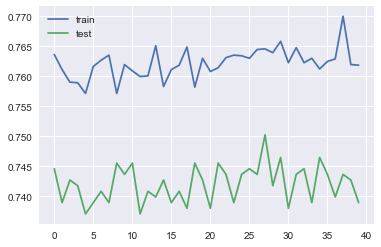

MPQADataset
Train precision 0.7618648507071766
Test precision 0.7389255419415646


In [47]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model_with_gradient(model, dataset, None, alpha=0.001, tag='default')

# Use tfidf, then $w$

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

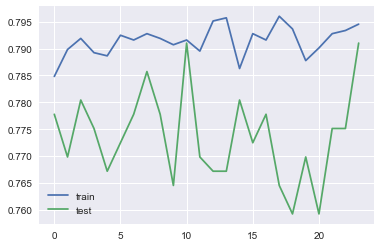

CRDataset
Train precision 0.7945245805122166
Test precision 0.791005291005291


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

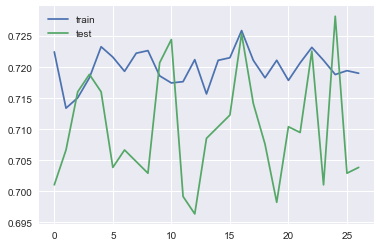

MRDataset
Train precision 0.7190203230849401
Test precision 0.703842549203374


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

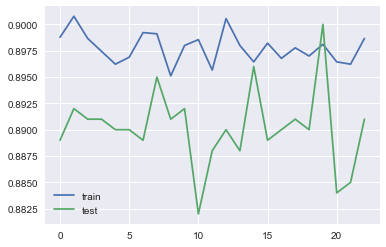

SUBJDataset
Train precision 0.8986666666666667
Test precision 0.891


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

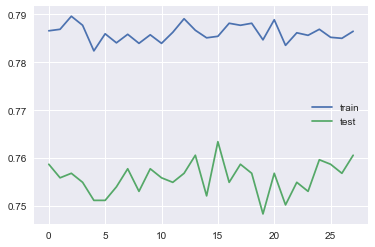

MPQADataset
Train precision 0.7864850707176532
Test precision 0.760603204524034


In [54]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model_with_gradient(model, dataset, None, alpha=0, tag='tfidf')
    models[(dataset.name(), 'tfidf')] = model

# Use tfidf, then updating $w$

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

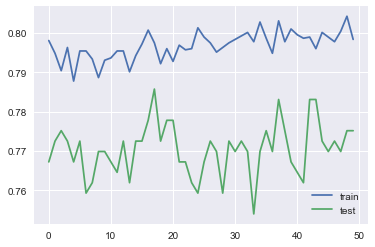

CRDataset
Train precision 0.7983514866058287
Test precision 0.7751322751322751


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

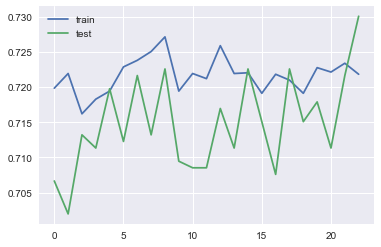

MRDataset
Train precision 0.721834288692027
Test precision 0.7300843486410497


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

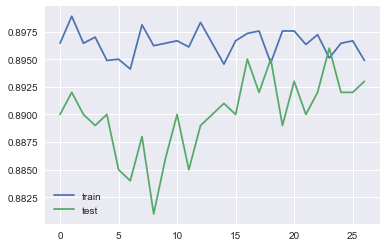

SUBJDataset
Train precision 0.8948888888888888
Test precision 0.893


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

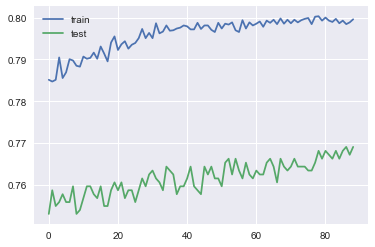

MPQADataset
Train precision 0.7995809324253536
Test precision 0.769085768143261


In [55]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model_with_gradient(model, dataset, None, alpha=0.01, tag='update_tfidf')
    models[(dataset.name(), 'update_w_tfidf')] = model

updating with smaller $\alpha$

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

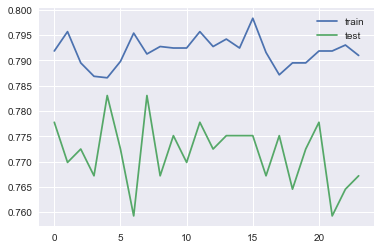

CRDataset
Train precision 0.790992051810421
Test precision 0.7671957671957672


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

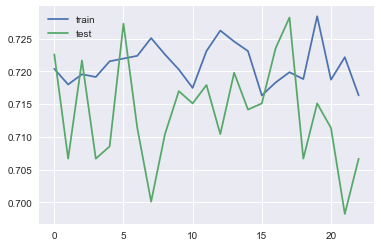

MRDataset
Train precision 0.7163105784262637
Test precision 0.7066541705716963


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

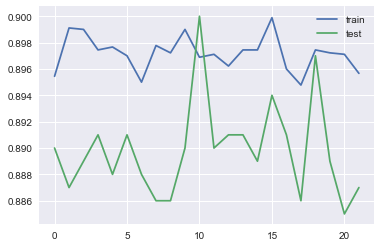

SUBJDataset
Train precision 0.8956666666666666
Test precision 0.887


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

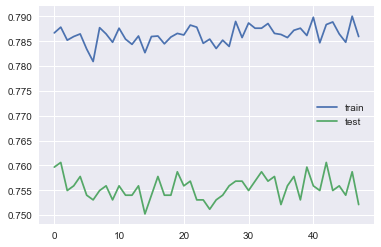

MPQADataset
Train precision 0.7859612362493452
Test precision 0.7521206409048068


In [59]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model_with_gradient(model, dataset, None, alpha=0.001, tag='update_tfidf')

In [63]:
models

{('CRDataset', 'tfidf'): <__main__.SimpleModel at 0x7f68281072e8>,
 ('CRDataset', 'update_w'): <__main__.SimpleModel at 0x7f681bfcf5f8>,
 ('CRDataset', 'update_w_tfidf'): <__main__.SimpleModel at 0x7f6821bfe320>,
 ('MPQADataset', 'tfidf'): <__main__.SimpleModel at 0x7f682c588828>,
 ('MPQADataset', 'update_w'): <__main__.SimpleModel at 0x7f682dc5d7b8>,
 ('MPQADataset', 'update_w_tfidf'): <__main__.SimpleModel at 0x7f68297817b8>,
 ('MRDataset', 'tfidf'): <__main__.SimpleModel at 0x7f682c5959e8>,
 ('MRDataset', 'update_w'): <__main__.SimpleModel at 0x7f6820f6dbe0>,
 ('MRDataset', 'update_w_tfidf'): <__main__.SimpleModel at 0x7f6828140b38>,
 ('SUBJDataset', 'tfidf'): <__main__.SimpleModel at 0x7f682c588470>,
 ('SUBJDataset', 'update_w'): <__main__.SimpleModel at 0x7f682db22e10>,
 ('SUBJDataset', 'update_w_tfidf'): <__main__.SimpleModel at 0x7f682cd72518>}

In [96]:
def print_words(model):
    joined = [(model.w[i], model.dictionary.id2token[i]) for i in range(len(model.w))]
    print(sorted(joined)[:10])
    print(sorted(joined, reverse=True)[:10])


In [97]:
print_words(models[('CRDataset', 'update_w')])             

[(0.19165961168118356, 'i'), (0.536119878499658, 'diaper'), (0.5591313707644328, 'camera'), (0.6041282542537751, '3'), (0.6096062635786245, 'am'), (0.6177891232289039, '!'), (0.6230397496640215, 'and'), (0.631554134970016, 'small'), (0.6854911651748009, 'does'), (0.6940634720630219, 'very')]
[(1.5441063579488148, "'t"), (1.4016201808815565, 'slow'), (1.3783179462134865, 'plus'), (1.3504821007114307, 'flaw'), (1.3380354413819362, 'perfect'), (1.3377297404918773, 'good'), (1.3348546791497697, 'bit'), (1.3332485045570608, 'excellent'), (1.2853755190363172, 'the'), (1.274170802274791, 'happy')]


In [98]:
print_words(models[('CRDataset', 'update_w_tfidf')])

[(0.870787405320415, ','), (0.8895121693484447, 'is'), (0.9081901397398893, 'for'), (0.9193934070498159, 'it'), (0.9214666048573534, 'this'), (0.9457857871758656, 'has'), (0.9555072078650438, 'very'), (0.9619235069360041, 'say'), (0.9624835857956233, 'screen'), (0.9660351992865219, 'antivirus')]
[(1.93926659535666, 'not'), (1.8725868820323326, 'only'), (1.6504188024217186, 'great'), (1.5842742791386453, "'t"), (1.5108537681251233, 'easy'), (1.3963054704949245, 'good'), (1.3693630157821195, 'after'), (1.326858766582417, 'excellent'), (1.3233014981015976, 'but'), (1.2719854194282094, 'bit')]


In [128]:
import pandas as pd
from itertools import groupby

In [136]:
list(groupby([1,2,3,4,4,2]))

[(1, <itertools._grouper at 0x7f6820ade9b0>),
 (2, <itertools._grouper at 0x7f6820add668>),
 (3, <itertools._grouper at 0x7f6820add898>),
 (4, <itertools._grouper at 0x7f6820add5f8>),
 (2, <itertools._grouper at 0x7f6820add7b8>)]

In [132]:
list(groupby(list(results.items()), key=lambda x: x[0][-1]))

[('MPQADataset', <itertools._grouper at 0x7f6820adb9b0>),
 ('SUBJDataset', <itertools._grouper at 0x7f6820adb978>),
 ('MRDataset', <itertools._grouper at 0x7f6820adbc18>),
 ('CRDataset', <itertools._grouper at 0x7f6820adb9e8>),
 ('MRDataset', <itertools._grouper at 0x7f6820adba58>),
 ('MPQADataset', <itertools._grouper at 0x7f6820adbcf8>),
 ('MRDataset', <itertools._grouper at 0x7f6820adbc88>),
 ('CRDataset', <itertools._grouper at 0x7f6820adbac8>),
 ('SUBJDataset', <itertools._grouper at 0x7f6820adbc50>),
 ('CRDataset', <itertools._grouper at 0x7f6820adbd30>),
 ('SUBJDataset', <itertools._grouper at 0x7f6820adbd68>),
 ('MRDataset', <itertools._grouper at 0x7f6820adbda0>),
 ('SUBJDataset', <itertools._grouper at 0x7f6820adbba8>),
 ('CRDataset', <itertools._grouper at 0x7f6820adba90>),
 ('MPQADataset', <itertools._grouper at 0x7f6820adbbe0>),
 ('SUBJDataset', <itertools._grouper at 0x7f6820adbb70>),
 ('CRDataset', <itertools._grouper at 0x7f6820adbb00>),
 ('MPQADataset', <itertools._gro